# Import packages

In [1]:
import numpy as np
import seaborn as sns
import sys
sys.path.append('../')
from utilities.vmd_post_func import *
from scipy import signal
import control

# Functions and Class

In [2]:
class VehicleDynamics():
    def __init__(self):
        # mass properties of vehicle
        self.Me = 204 # taken from https://autotrends.org/how-much-does-car-engine-weigh/
        self.Mb = 1323
        self.Iyy = 1000
        self.Mf = 100
        self.Mr = 80
        
        # stiffness values
        self.Km = 8.5e5 # tuned according to frequency of mount 12-15 Hz.
        self.Kfs = 30e3
        self.Krs = 30e3
        self.Kft = 220e3
        self.Krt = 220e3
        
        # damping values
        self.Cm = 1380 # https://dc.uwm.edu/cgi/viewcontent.cgi?article=1349&context=etd
        self.Cfs = 3.5e3
        self.Crs = 3.5e3
        
        # CG location
        self.a = 1.076
        self.b = 1.614

def get_dynamic_matrices(vehicle_object):
    """ This function is used to compute the K, C, and M matrices of a 4 dof vehicle model.
    
    Inputs:
        vehicle_oject (object): vehicle class object that contains the vehicle inputs
    
    Returns:
        K_mat, C_mat, M_mat: K, C, and M matrices.
    """
    # call vehicle dynamic objects to obtain vehicle properties
    Me,Mb,Iyy,Mf,Mr = vehicle_object.Me,vehicle_object.Mb,vehicle_object.Iyy,vehicle_object.Mf,vehicle_object.Mr # mass of engine, body, and unsprung mass
    Km,Kfs,Krs,Kft,Krt = vehicle_object.Km,vehicle_object.Kfs,vehicle_object.Krs,vehicle_object.Kft,vehicle_object.Krt # stiffness values for the engine mount, vehicle suspension, and tire (N/m)
    Cm,Cfs,Crs = vehicle_object.Cm,vehicle_object.Cfs,vehicle_object.Crs # damping coefficient for engine mount and suspension (N-s/m)
    a,b = vehicle_object.a,vehicle_object.b # CG location (m)
    
    # create variables that will be used
    # collect K and M matrices
    K_mat = np.array([[(Kfs+Krs+Km),-(-Kfs*a+Krs*b-Km*a),-Kfs,-Krs,-Km],
                    [-(-Kfs*a+Krs*b-Km*a),Kfs*a**2+Krs*b**2+Km*a**2,-Kfs*a,Krs*b,-Km*a],
                    [-Kfs,-Kfs*a,Kfs+Kft,0,0],
                    [-Krs,b*Krs,0,Krs+Krt,0],
                    [-Km,-Km*a,0,0,Km]]) # type: ignore 
    C_mat = np.array([[(Cfs+Crs+Cm),-(-Cfs*a+Crs*b-Cm*a),-Cfs,-Crs,-Cm],# type: ignore
                    [-(-Cfs*a+Crs*b-Cm*a),Cfs*a**2+Crs*b**2+Cm*a**2,-Cfs*a,Crs*b,-Cm*a],
                    [-Cfs,-Cfs*a,Cfs,0,0],
                    [-Crs,b*Crs,0,Crs,0],
                    [-Cm,-Cm*a,0,0,Cm]])
    M_mat = np.diag((Mb,Iyy,Mf,Mr,Me))
    
    return K_mat, C_mat, M_mat

def get_ss(veh_params):
    """This function is used to compute the state-space model of a vehicle and convert it into a transfer function using MIMO.

    Args:
        veh_params (object): object containing vehicle properties.

    returns:
        [LTI]: LTI class transfer function.
    """
    K_mat, C_mat, M_mat = get_dynamic_matrices(veh_params)
    dof = K_mat.shape[0]
# define state space model:
    # state matrix (A):
    A = np.zeros((2*dof,2*dof))
    A[:dof,dof:] = np.eye(dof)
    A[dof:,dof:] = -np.linalg.inv(M_mat)@K_mat
    A[dof:,:dof] = -np.linalg.inv(M_mat)@C_mat

    # input matrix (B):
    B = np.zeros((2*dof,1))
    B[-1] = 1
    
    # output matrix (C):
    C = np.zeros((2*dof,2*dof))
    C[:dof,:dof] = np.eye(dof)
    C[dof:,dof:] = -np.linalg.inv(M_mat)@K_mat
    C[dof:,:dof] = -np.linalg.inv(M_mat)@C_mat
    
    # D matrix
    D = np.zeros((2*dof,1))
    D[-1] = 1
    
    # assemble statespace:
    ss_sys = signal.StateSpace(A, B, C, D)
    return ss_sys

def get_tf(veh_params):
    """This function is used to compute the state-space model of a vehicle and convert it into a transfer function using MIMO.

    Args:
        veh_params (object): object containing vehicle properties.

    returns:
        [LTI]: LTI class transfer function.
    """
    K_mat, C_mat, M_mat = get_dynamic_matrices(veh_params)
    dof = K_mat.shape[0]
# define state space model:
    # state matrix (A):
    A = np.zeros((2*dof,2*dof))
    A[:dof,dof:] = np.eye(dof)
    A[dof:,:dof] = -np.linalg.inv(M_mat)@K_mat
    A[dof:,dof:] = -np.linalg.inv(M_mat)@C_mat

    # input matrix (B):
    B = np.zeros((2*dof,1))
    B[-1] = 1
    
    # output matrix (C):
    C = np.zeros((2*dof,2*dof))
    C[:dof,:dof] = np.eye(dof)
    C[dof:,:dof] = -np.linalg.inv(M_mat)@K_mat
    C[dof:,dof:] = -np.linalg.inv(M_mat)@C_mat
    
    # D matrix
    D = np.zeros((2*dof,1))
    D[-1] = 1
    
    # assemble statespace:
    ss_sys = control.ss(A, B, C, D)
    return control.ss2tf(ss_sys)

# Plot format definition

In [3]:
sns.set_style({'font.family':'Times New Roman','grid.linestyle':'--','grid.color':'k','axes.facecolor':'white','axes.edgecolor':'k','axes.grid':True})
sns.set_context({'font.size':32,'grid.linewidth':1})

# Eigenfrequencies to tune engine mount stiffness

In [4]:
from scipy import linalg
veh_inputs = VehicleDynamics()
veh_inputs.Cm=0.0
veh_inputs.Km=10.5e5
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)

# calculate eigenvectors and values
wn,v = linalg.eig(K_mat,M_mat)

fn = np.sqrt(np.real(wn))/(2*np.pi)
print(fn)
print(np.around(v,1))
# print(v)

[13.48445898  0.87087552  1.51664636  8.91339923  7.96405462]
[[-0.1  0.6  0.3 -0.  -0. ]
 [-0.2  0.2 -0.8  0.  -0. ]
 [ 0.   0.1 -0.1 -0.   1. ]
 [-0.   0.   0.2  1.   0. ]
 [ 1.   0.8 -0.5  0.  -0. ]]


# Define transfer function of half-car model with engine ontop

Text(0, 0.5, 'Acceleration $\\left( \\frac{m/s^2}{N} \\right)$')

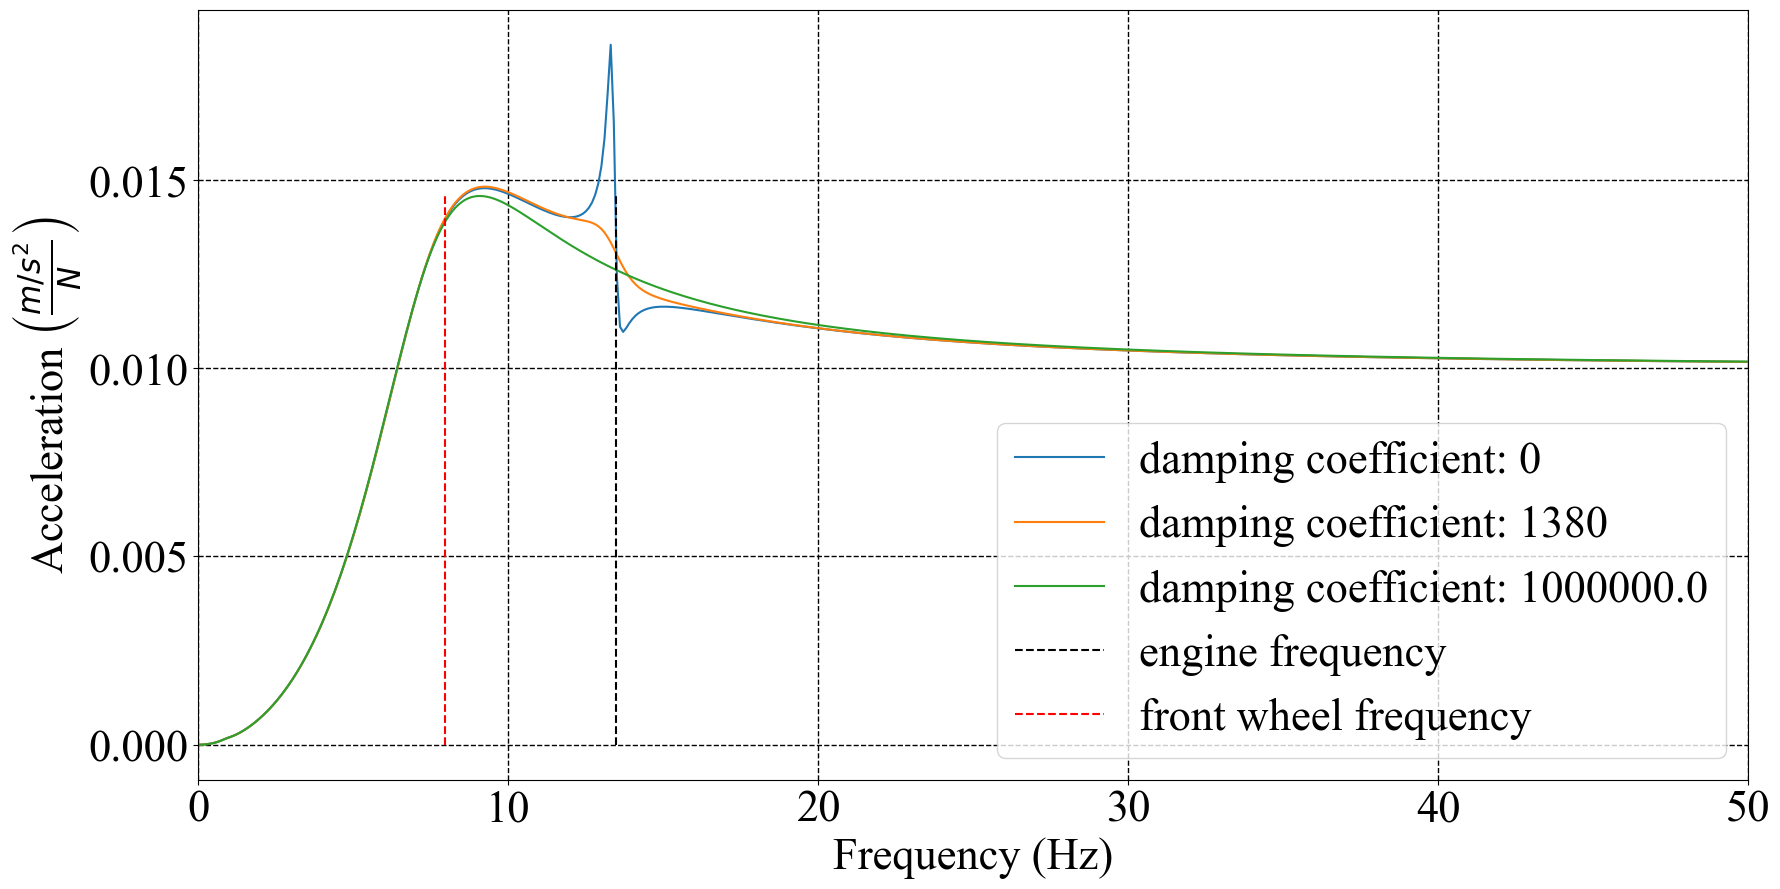

In [5]:
# define frequency vector
f = crange(0,500,0.1)
w = 2*np.pi*f
s = 1j*w
Cm_ = [0,1380,1e6]
fig,axs = plt.subplots(figsize=(20,10))
for Cm_i in Cm_:
    # change damping
    veh_inputs.Cm= Cm_i
    K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
    # define empty vector to store frf
    frf_engine_front_wheel = np.zeros(len(f))
    frf_engine_rear_wheel = np.zeros(len(f))
    for idx,s_ in enumerate(s):
        # compute transfer function
        vehicle_tf = np.linalg.inv(K_mat+C_mat*s_+M_mat*s_**2)
        
        # store frf
        frf_engine_front_wheel[idx] = np.abs(vehicle_tf[2,2]*s_**2)
        frf_engine_rear_wheel[idx] = np.abs(vehicle_tf[3,3]*s_**2)
    sns.lineplot(x=f,y=frf_engine_front_wheel,ax=axs,label=f'damping coefficient: {Cm_i}')
axs.set_xlim([0,50])
axs.vlines([fn[0]],ymin=0,ymax=frf_engine_front_wheel.max(),color='k',ls='--',label='engine frequency')
axs.vlines([fn[-1]],ymin=0,ymax=frf_engine_front_wheel.max(),color='r',ls='--',label='front wheel frequency')
axs.legend();axs.set_xlabel('Frequency (Hz)'); axs.set_ylabel(r'Acceleration $\left( \frac{m/s^2}{N} \right)$')

# Transfer function of unsprung mass between vehicle with and without engine mount

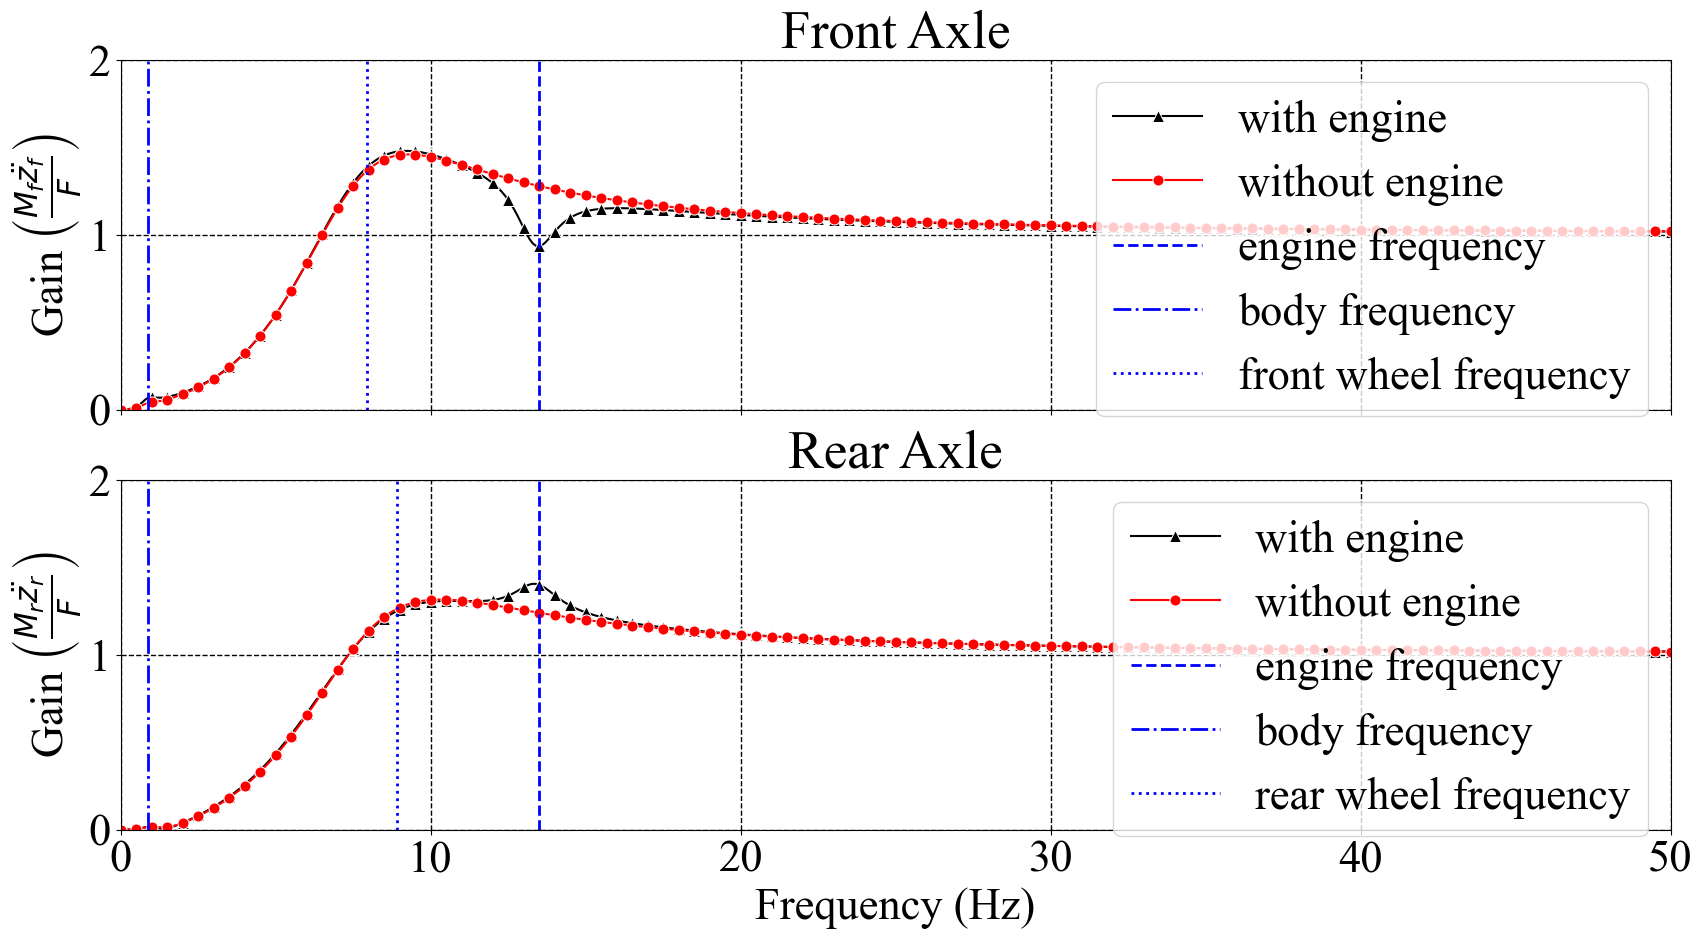

In [6]:
# define frequency vector
f = crange(0,500,0.1)
w = 2*np.pi*f
s = 1j*w
fig,axs = plt.subplots(2,1,figsize=(20,10),sharex=True)

# keep engine effects
veh_inputs.Cm = 1380 
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_front_with_engine = np.zeros(len(f))
frf_engine_rear_with_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat+C_mat*s_+M_mat*s_**2)
    
    # store frf
    frf_engine_front_with_engine[idx] = np.abs(veh_inputs.Mf*np.sum(vehicle_tf[2,:])*s_**2)
    frf_engine_rear_with_engine[idx] = np.abs(veh_inputs.Mr*np.sum(vehicle_tf[3,:])*s_**2)

sns.lineplot(x=f,y=frf_engine_front_with_engine,ax=axs[0],label=f'with engine',ls='-',marker='^',markersize=8,markevery=5,color='k')

sns.lineplot(x=f,y=frf_engine_rear_with_engine,ax=axs[1],label=f'with engine',ls='-',marker='^',markersize=8,markevery=5,color='k')

# remove engine effects
veh_inputs.Cm = 0
veh_inputs.Km = 0
veh_inputs.Me = 0 
veh_inputs.Mb = 1323 + 204
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_front_no_engine = np.zeros(len(f))
frf_engine_rear_no_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat[0:4,0:4]+C_mat[0:4,0:4]*s_+M_mat[0:4,0:4]*s_**2)
    
    # store frf
    frf_engine_front_no_engine[idx] = np.abs(veh_inputs.Mf*np.sum(vehicle_tf[2,:])*s_**2)
    frf_engine_rear_no_engine[idx] = np.abs(veh_inputs.Mr*np.sum(vehicle_tf[3,:])*s_**2)
sns.lineplot(x=f,y=frf_engine_front_no_engine,ax=axs[0],ls='-',marker='o',markersize=8,label=f'without engine',markevery=5,color='red')
axs[0].set_xlim([0,50]);axs[0].set_ylim([0,2])
axs[0].vlines([fn[0]],ymin=0,ymax=2,color='b',ls='--',lw=2,label='engine frequency')
axs[0].vlines([fn[1]],ymin=0,ymax=2,color='b',ls='-.',lw=2,label='body frequency')
axs[0].vlines([fn[-1]],ymin=0,ymax=2,color='b',ls=':',lw=2,label='front wheel frequency')
axs[0].set_xlabel('Frequency (Hz)'); axs[0].set_ylabel(r'Gain $\left( \frac{M_f\ddot{z_f}}{F} \right)$')
axs[0].legend(loc='upper right');axs[0].set_title('Front Axle')

sns.lineplot(x=f,y=frf_engine_rear_no_engine,ax=axs[1],label=f'without engine',ls='-',marker='o',markersize=8,markevery=5,color='red')
axs[1].set_xlim([0,50]);axs[1].set_ylim([0,2])
axs[1].vlines([fn[0]],ymin=0,ymax=2,color='b',ls='--',lw=2,label='engine frequency')
axs[1].vlines([fn[1]],ymin=0,ymax=2,color='b',ls='-.',lw=2,label='body frequency')
axs[1].vlines([fn[-2]],ymin=0,ymax=2,color='b',ls=':',lw=2,label='rear wheel frequency')
axs[1].set_xlabel('Frequency (Hz)'); axs[1].set_ylabel(r'Gain $\left( \frac{M_r\ddot{z_r}}{F} \right)$')
axs[1].legend(loc='upper right');axs[1].set_title('Rear Axle')

fig.savefig('../results/tf_rev_2.svg')

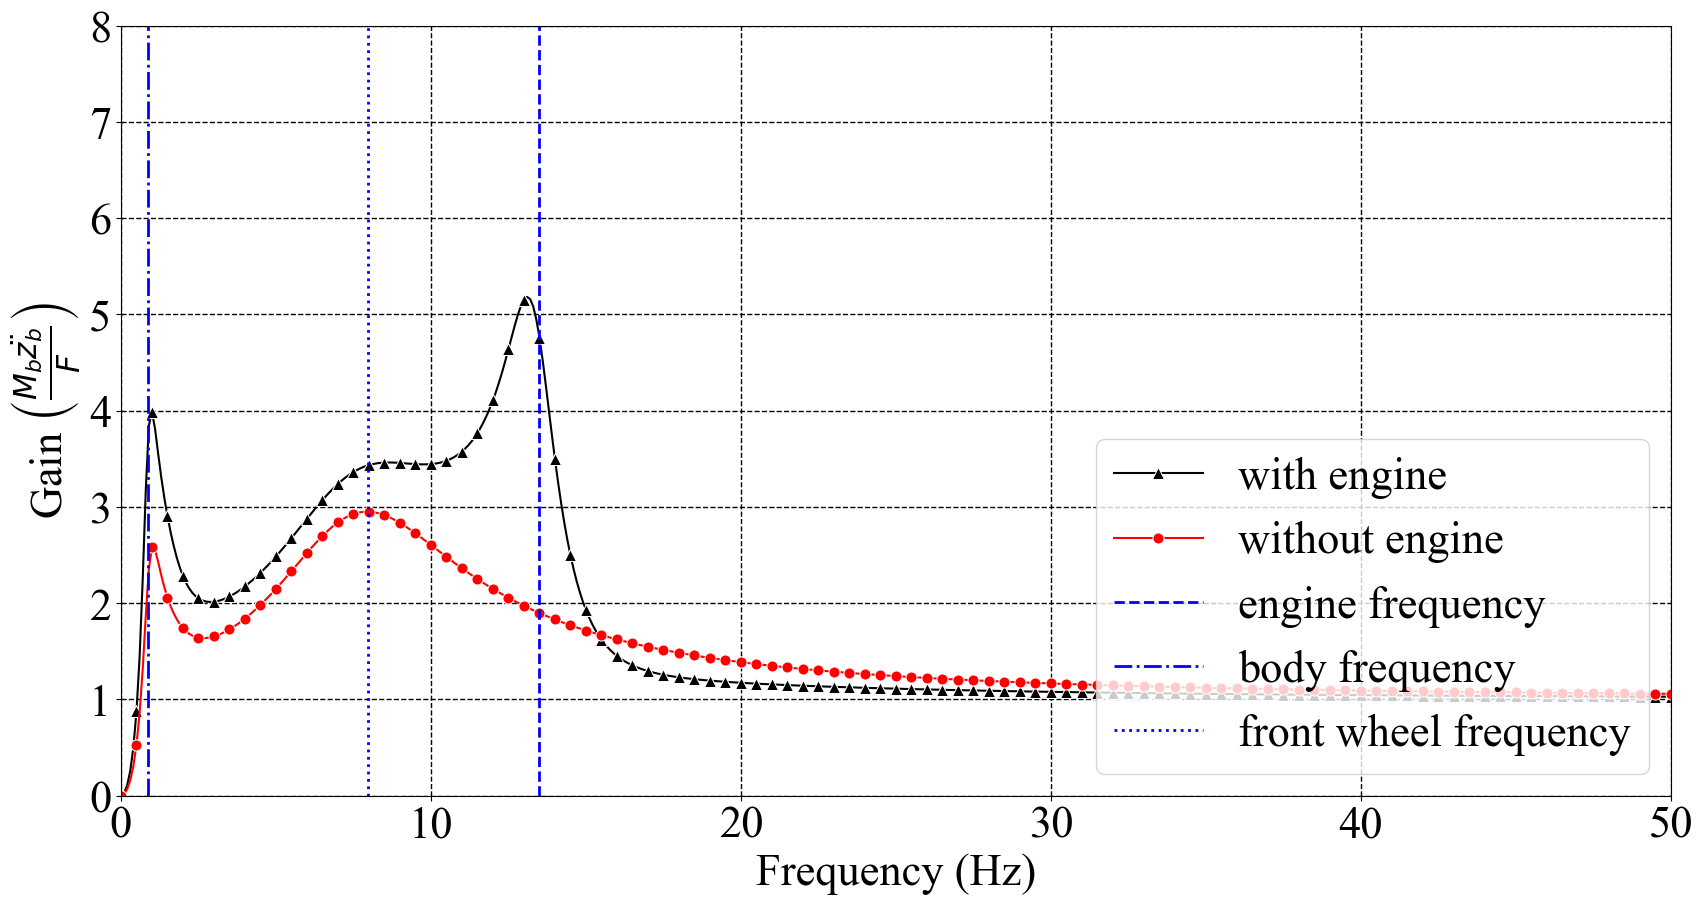

In [7]:
# define frequency vector
f = crange(0,500,0.1)
w = 2*np.pi*f
s = 1j*w
fig,axs = plt.subplots(figsize=(20,10),sharex=True)

# keep engine effects
veh_inputs.Cm = 1380 
veh_inputs.Km = 10.5e5 
veh_inputs.Me = 204
veh_inputs.Mb = 1323
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_body_with_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat+C_mat*s_+M_mat*s_**2)
    
    # store frf
    frf_engine_body_with_engine[idx] = np.abs(veh_inputs.Mb*np.sum(vehicle_tf[0,:])*s_**2)

sns.lineplot(x=f,y=frf_engine_body_with_engine,ax=axs,label='with engine',ls='-',marker='^',markersize=8,markevery=5,color='k')

# remove engine effects
veh_inputs.Cm = 0
veh_inputs.Km = 0
veh_inputs.Me = 0 
veh_inputs.Mb = 1323 + 204
K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)
# define empty vector to store frf
frf_engine_body_no_engine = np.zeros(len(f))
for idx,s_ in enumerate(s):
    # compute transfer function
    vehicle_tf = np.linalg.inv(K_mat[0:4,0:4]+C_mat[0:4,0:4]*s_+M_mat[0:4,0:4]*s_**2)
    
    # store frf
    frf_engine_body_no_engine[idx] = np.abs(veh_inputs.Mb*np.sum(vehicle_tf[0,:])*s_**2)
sns.lineplot(x=f,y=frf_engine_body_no_engine,ax=axs,ls='-',marker='o',markersize=8,label='without engine',markevery=5,color='red')
axs.set_xlim([0,50]);axs.set_ylim([0,8])
axs.vlines([fn[0]],ymin=0,ymax=8,color='b',ls='--',lw=2,label='engine frequency')
axs.vlines([fn[1]],ymin=0,ymax=8,color='b',ls='-.',lw=2,label='body frequency')
axs.vlines([fn[-1]],ymin=0,ymax=8,color='b',ls=':',lw=2,label='front wheel frequency')
axs.legend(loc='lower right');axs.set_xlabel('Frequency (Hz)'); axs.set_ylabel(r'Gain $\left( \frac{M_b\ddot{z_b}}{F} \right)$')
fig.savefig('../results/tf_body_rev_2.svg')

# Run engine simulation
Transmissibility is used to quantify the amount of vibration being transmitted into the front and rear axles from the engine vibrations
## Input engine force

<AxesSubplot: >

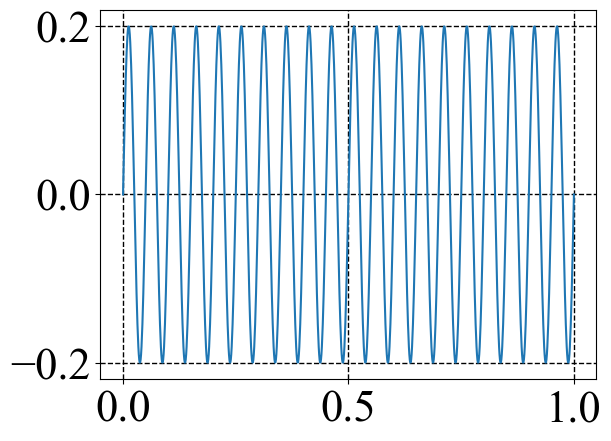

In [8]:
veh_inputs.Cm = 5000 
veh_inputs.Km = 10.5e5
veh_inputs.Me = 204 
veh_inputs.Mb = 1323 + 204
veh_ss = get_ss(veh_inputs)
t = crange(0,1,0.001)
A_inp = 0.2 # acceleration amplitude
P_e = A_inp*np.sin(2*np.pi*(20*t))
sns.lineplot(x=t,y=P_e)

## Scipy lsim

In [9]:
t,y,x = signal.lsim(veh_ss,P_e,t)
x.shape

(1001, 10)

## Organize states and outputs into dataframes

In [10]:
states_df = pd.DataFrame(np.hstack((np.reshape(t,(len(t),1)),x)),columns=['time','b_bnce_d','b_pch_d','f_axl_d','r_axl_d','e_d',
                                                               'b_bnce_v','b_pch_v','f_axl_v','r_axl_v','e_v'])
states_df

,time,b_bnce_d,b_pch_d,f_axl_d,r_axl_d,e_d,b_bnce_v,b_pch_v,f_axl_v,r_axl_v,e_v
0,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
1,0.001,2.756498e-10,4.451290e-10,3.463018e-11,-2.343561e-11,2.104386e-09,9.222330e-07,0.000001,1.398129e-07,-9.281361e-08,0.000006
2,0.002,2.643932e-09,4.196059e-09,4.966480e-10,-3.159750e-10,1.336713e-08,4.212950e-06,0.000007,9.061589e-07,-5.608482e-07,0.000018
3,0.003,9.487162e-09,1.480488e-08,2.090392e-09,-1.275278e-09,4.004450e-08,9.857809e-06,0.000015,2.399781e-06,-1.418146e-06,0.000036
4,0.004,2.311073e-08,3.547697e-08,5.524244e-09,-3.263521e-09,8.781182e-08,1.775255e-05,0.000027,4.576501e-06,-2.608760e-06,0.000060
...,...,...,...,...,...,...,...,...,...,...,...
996,0.996,7.262651e-06,4.186144e-06,1.568524e-06,5.202356e-08,1.188136e-05,-1.520697e-04,-0.000214,-4.517126e-05,2.346654e-05,-0.000400
997,0.997,7.106614e-06,3.972361e-06,1.522762e-06,7.502757e-08,1.147941e-05,-1.595931e-04,-0.000213,-4.623352e-05,2.248080e-05,-0.000403
998,0.998,6.944299e-06,3.761298e-06,1.476300e-06,9.686703e-08,1.107740e-05,-1.646103e-04,-0.000209,-4.656666e-05,2.114051e-05,-0.000400
999,0.999,6.778255e-06,3.556278e-06,1.429873e-06,1.171975e-07,1.068166e-05,-1.670423e-04,-0.000201,-4.616543e-05,1.946683e-05,-0.000391


In [11]:
outputs_df = pd.DataFrame(np.hstack((np.reshape(t,(len(t),1)),y[:,5:])),columns=['time','b_bnce_acc','b_pch_acc','f_axl_acc','r_axl_acc','e_acc'])
outputs_df

,time,b_bnce_acc,b_pch_acc,f_axl_acc,r_axl_acc,e_acc
0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001,0.002091,0.003325,0.000405,-0.000261,0.009267
2,0.002,0.004485,0.006892,0.001134,-0.000671,0.015503
3,0.003,0.006795,0.010102,0.001845,-0.001034,0.021207
4,0.004,0.008980,0.012923,0.002497,-0.001337,0.026309
...,...,...,...,...,...,...
996,0.996,-0.008744,-0.000653,-0.001422,-0.000803,-0.006477
997,0.997,-0.006290,0.002718,-0.000699,-0.001166,-0.000126
998,0.998,-0.003736,0.006047,0.000034,-0.001511,0.006226
999,0.999,-0.001124,0.009280,0.000767,-0.001832,0.012481


## Transmissibility

In [33]:
f_inp = crange(0.1,60,0.01)
t = crange(0,0.5,0.001)
A_inp = 1 # acceleration amplitude

veh_inputs.Cm = 500
veh_inputs.Km = 10.5e3
veh_inputs.Me = 204 
veh_inputs.Mb = 1323 + 204
veh_ss = get_ss(veh_inputs)

K_mat, C_mat, M_mat = get_dynamic_matrices(veh_inputs)

# calculate eigenvectors and values
wn,v = linalg.eig(K_mat,M_mat)

fn = np.sqrt(np.real(wn))/(2*np.pi)

# preallocate arrays:
trans_arr = np.zeros(len(f_inp))
for idx,f_inp_i in enumerate(f_inp):
    P_e = A_inp*np.sin(2*np.pi*(f_inp_i*t))
    t,y,x = signal.lsim(veh_ss,P_e,t)

    # get displacement and velocity states
    ze = y[:,4] # engine displacement
    ze_dot = x[:,9] # engine velocity
    zf = y[:,0]+y[:,1]*veh_inputs.a # front body displacement
    zf_dot = x[:,5]+x[:,6]*veh_inputs.a # front body velocity
    
    # compute transmitted forces
    f_k = veh_inputs.Km*(ze-zf)+veh_inputs.Cm*(ze_dot-zf_dot)
    trans_arr[idx] = np.max(np.abs(f_k))/A_inp 

In [34]:
print(f_inp/fn[2])
print(np.round(v,1))

[ 0.13010817  0.14311899  0.15612981 ... 78.03888119 78.05189201
 78.06490283]
[[-0.   0.   0.4  0.4  0. ]
 [ 0.   0.   0.1 -0.2  0.8]
 [-0.  -1.   0.1  0.   0.1]
 [ 1.  -0.   0.   0.1 -0.1]
 [-0.  -0.   0.9 -0.9 -0.6]]


## Plot transmissibility curves

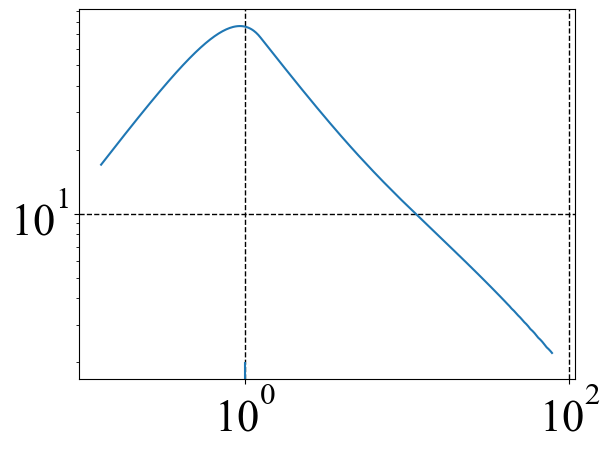

In [35]:
fig,axs = plt.subplots()
sns.lineplot(x=f_inp/fn[2],y=trans_arr,ax=axs)
axs.vlines(1,ymin=0,ymax=2)
axs.set_yscale('log')
axs.set_xscale('log')

0.0643861184144552
0.1286483848455786
0.19266326308809684
0.25630784758808706
0.3194601765095133
0.38199954209752107
0.44380679745028573
0.5047646588221704
0.5647580025946028
0.6236741560673802
0.6814031812419458
0.7378381507896415
0.7928754154216762
0.84641486190391
0.8983601609879387
0.9486190045608025
0.9971033313483818
1.0437295405424318
1.088418692757942
1.131096697765924
1.171694488486992
1.2101481807727128
1.2463992185447488
1.2803945039063065
1.3120865118855731
1.3414333895175385
1.3683990390176501
1.3929531848487402
1.4150714245311495
1.4347352630947092
1.451932131120395
1.4666553863684881
1.4789042990391876
1.4886840207603076
1.496005537445146
1.5008856062115348
1.503346676599962
1.5034167963753378
1.5011295022420192
1.4965236958459867
1.4896435054810737
1.4805381339576709
1.4692616931321998
1.4558730256343497
1.4404355143653569
1.4230168803755754
1.4036889697622554
1.3825275302592455
1.3596119782187548
1.3350251567116136
1.3100221286894769
1.2859339372058276
1.26271352460983

(0.034, 10)

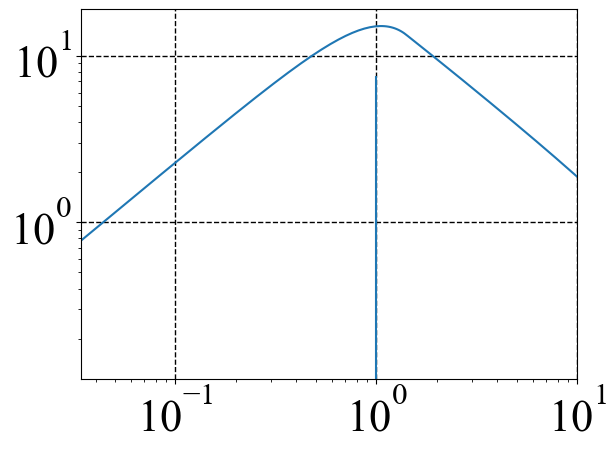

In [14]:
# spring mass example
k_ = 100
c_ = 1000
m_ = 20

A_inp = 0.1
# compute natural frequency
fn = np.sqrt(k_/m_)/(2*np.pi)

# state space matrices
A = np.array([[0,1],[-k_/m_,-c_/m_]])
B = np.array([[0],[1]])
C = np.array([[1,0],[-k_/m_,-c_/m_]])
D = np.array([[0],[1]])

# assemble state space
sm_ss = signal.StateSpace(A,B,C,D)

# input frequency vector
f_inp = crange(0.01,30,0.01)

# preallocate arrays:
trans_arr = np.zeros(len(f_inp))

for idx,f_inp_i in enumerate(f_inp):
    P_e = A_inp*np.sin(2*np.pi*(f_inp_i*t))
    t,y,x = signal.lsim(sm_ss,P_e,t)

    # get displacement and velocity states
    ze = y[:,0] # engine displacement
    ze_dot = x[:,0] # engine velocity
    
    # compute transmitted forces
    f_k = k_*(ze)+c_*(ze_dot)
    print(np.max(f_k))
    trans_arr[idx] = np.max(f_k)/A_inp

fig,axs = plt.subplots()
sns.lineplot(x=f_inp/fn,y=trans_arr,ax=axs)
axs.vlines(1,ymin=0,ymax=7.5)
axs.set_yscale('log');axs.set_xscale('log')
axs.set_xlim([0.034,10])



# Calculate PSD

In [15]:
f,PSD = get_psd_welch(y,0.1,1000)

IndexError: index 9 is out of bounds for axis 1 with size 2

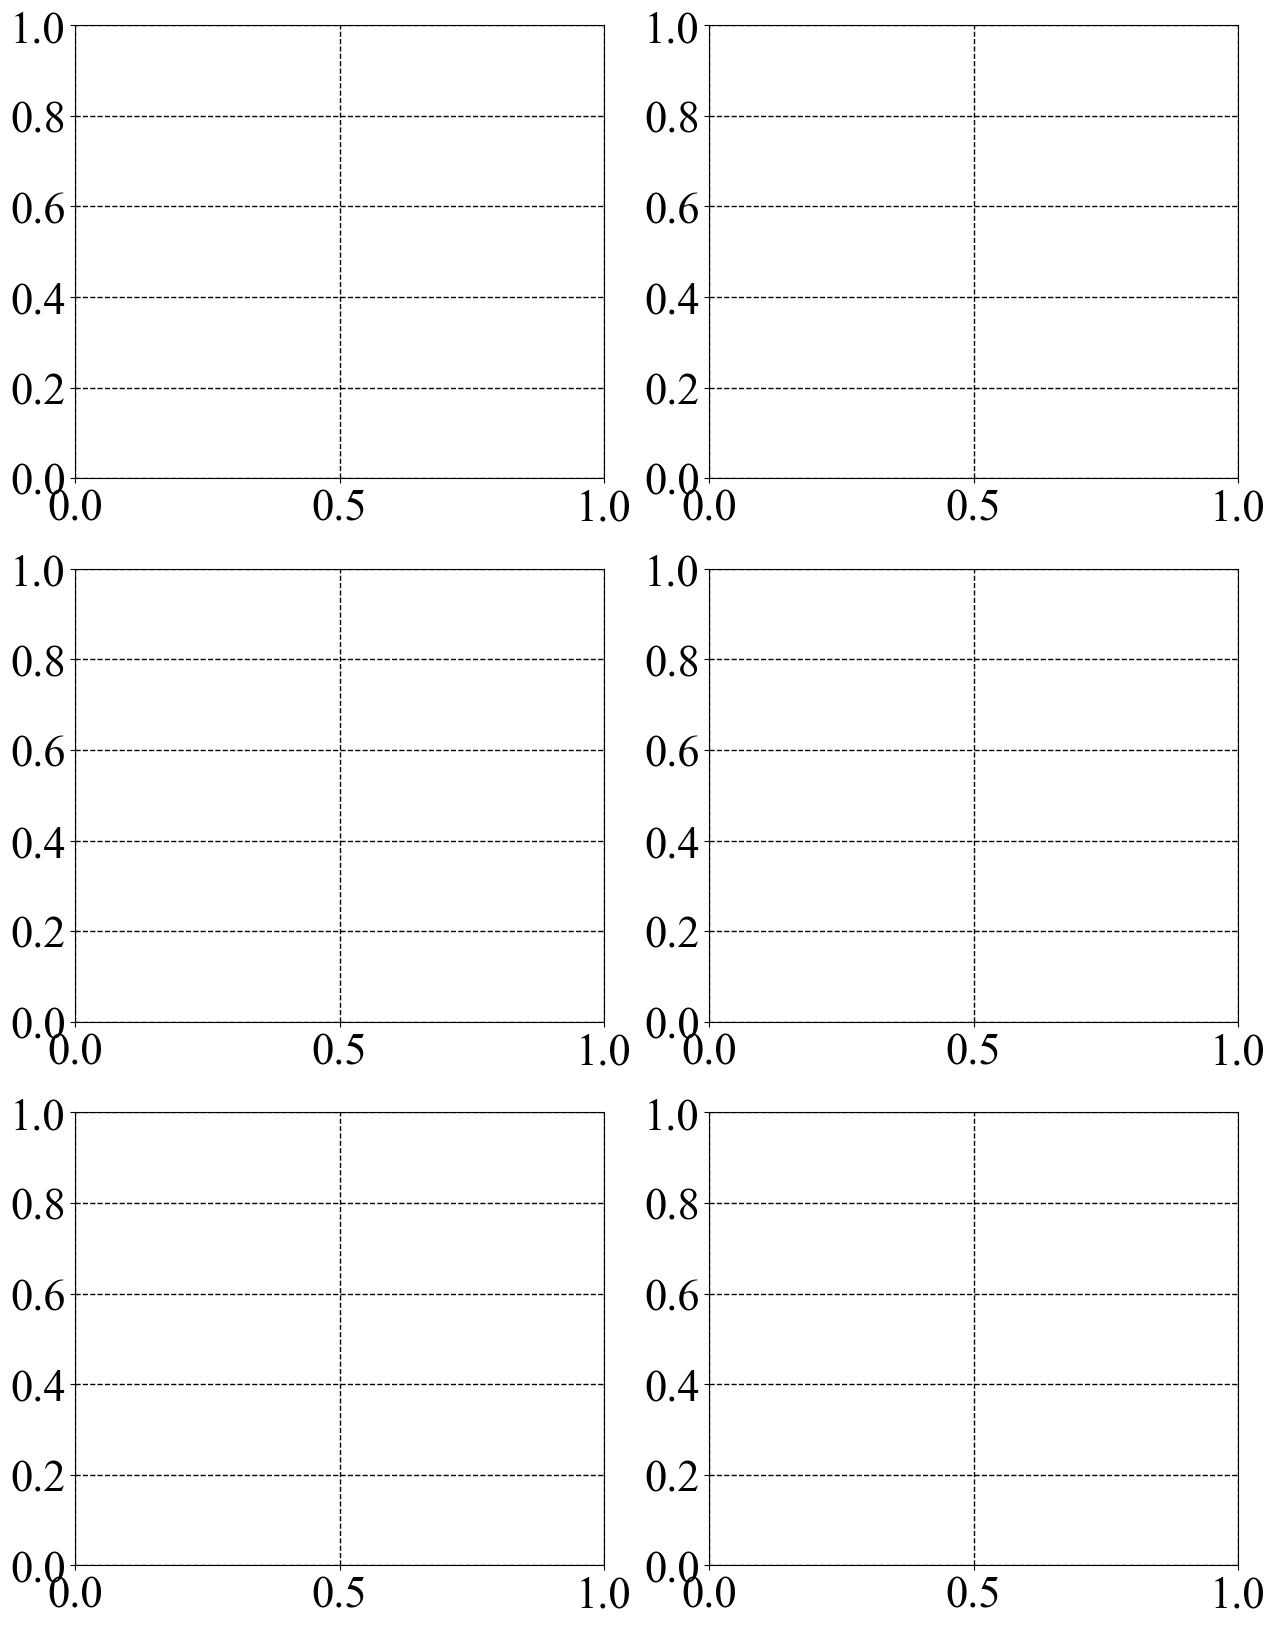

In [16]:
fig,axs = plt.subplots(3,2,figsize=(15,20))
sns.lineplot(x=t,y=y[:,9],color='k',lw=2,ax=axs[0,0]);axs[0,0].set_title('engine')
sns.lineplot(x=t,y=y[:,7],color='k',lw=2,ax=axs[1,0]);axs[1,0].set_title('front axle')
sns.lineplot(x=t,y=y[:,8],color='k',lw=2,ax=axs[2,0]);axs[2,0].set_title('rear axle')

sns.lineplot(x=f,y=PSD[:,9],color='k',lw=2,ax=axs[0,1]);axs[0,1].set_xlim([0,50])
sns.lineplot(x=f,y=PSD[:,7],color='k',lw=2,ax=axs[1,1]);axs[1,1].set_xlim([0,50])
sns.lineplot(x=f,y=PSD[:,8],color='k',lw=2,ax=axs[2,1]);axs[2,1].set_xlim([0,50])

In [ ]:
tf = get_tf(veh_inputs)

In [ ]:
dir(tf)

In [ ]:
tf

In [ ]:
tf.damp()[0]/(2*np.pi)

In [ ]:
fn_tf,fn_idx=np.unique(tf.damp()[0]/(2*np.pi),return_index=True)
fn_tf

In [ ]:
tf.damp()[1][fn_idx]/(2*np.pi)*100

In [ ]:
mag,phase,omega = control.freqresp(tf,w)

In [ ]:
fig,axs = plt.subplots()
sns.lineplot(x=omega/(2*np.pi),y=np.reshape(mag[7,:,:],len(omega)),ax=axs)
axs.set_xlim([0,50])